# Metapopulation Agent-Based SEIR Model

## Framework 
* Data collection and wrangling in Python 
* Modelling in Julia 

## To-Do List
1. Implement `move_to_work` and `move_back_home` methods
1. Implement `I_a` and `I_s` compartments
1. Think about diagnostic module
1. Think about how to implement delays (e.g. incubation period, onset of symptoms, ...)
1. Implement age-stratified susceptibility and recovery/death rates. Read Davies, N.G., Klepac, P., Liu, Y. et al. [Age-dependent effects in the transmission and control of COVID-19 epidemics](https://doi.org/10.1038/s41591-020-0962-9). *Nature Medicine* 26, 1205–1211 (2020).

## Modules

In [1]:
# Data Management 
using DataFrames, DataFramesMeta, DrWatson, Queryverse
# Statistics
using StatsBase, Distributions, Random
# Graphs 
using LightGraphs, SimpleWeightedGraphs, GraphIO, GraphPlot
# Modelling
using Agents
# Numerical Computation 
using LinearAlgebra
# Data Visualization
using Plots, AgentsPlots, PlotThemes
# Python Interface
###using PyCall 
###nx = pyimport("networkx");

## Data 

### Population 

In [ ]:
population_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/ProvincialPopulation.csv"));
age_population_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/AgeStratifiedProvincialPopulation.csv"));

# ADD POPULATION DATA PATHS 
### PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/ProvincialPopulation.csv"
### PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/CSV/2020/ProvincialPopulation.csv"

# ADD AGE-STRATIFIED POPULATION DATA PATHS 
### PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/AgeStratifiedProvincialPopulation.csv"
### PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/CSV/2020/AgeStratifiedProvincialPopulation.csv"

### Contact 

In [ ]:
# Load contact data
contact_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/ContactEdgeList.csv"))
# Build contact graph 
contact_graph = SimpleWeightedDiGraph(contact_data[1].+1, contact_data[2].+1, contact_data[3]);

# ADD CONTACT DATA PATHS 
### PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/ContactEdgeList.csv"
### PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/CSV/2020/ContactEdgeList.csv"

### Mobility

In [4]:
# Load mobility data
mobility_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/MobilityFlow.csv"))
# Build mobility graph 
mobility_graph = SimpleWeightedDiGraph(mobility_data[1], mobility_data[2], mobility_data[3])

# Remove the 104th node: provincial code doesn't exist
rem_vertex!(mobility_graph, 104)
# Remove the 105th node: provincial code doesn't exist
rem_vertex!(mobility_graph, 104)
# Remove the 106th node: provincial code doesn't exist
rem_vertex!(mobility_graph, 104)
# Remove the 107th node: provincial code doesn't exist
rem_vertex!(mobility_graph, 104);

# ADD MOBILITY DATA PATHS 
### PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/MobilityFlow.csv"
### PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/CSV/2020/MobilityFlow.csv"

## Agent Type 

In [5]:
# Voter Definition
mutable struct Patient <: AbstractAgent
    id::Int          # identity code ∈ ℕ               
    pos::Int         # location node ∈ ℕ 
    age_group::Int   # age group ∈ [1,16] ⊂ ℕ
    home::Int        # household node ∈ ℕ
    #work::Int       # workplace node ∈ ℕ
    status::Symbol   # ∈ {S,E,I_as,RD}
end;

## Behaviors

In [26]:
# Mobility Dynamics
function migrate!(agent, model)
    agent.status == :D && return
    source = agent.pos
    x = [outneighbor for outneighbor in LightGraphs.weights(model.space.graph)[source,:]]
    #outneighbors = node_neighbors(agent, model; neighbor_type=:out)
    distribution = DiscreteNonParametric(1:(model.M), x./sum(x))
    target = rand(distribution)
    if target ≠ source
        agent.pos = target #move_agent!(agent, target, model)
    end
end

# Contact Dynamics 
function contact!(agent, model)
    neighbors = get_node_agents(agent.pos, model)
    contacted_agents = []
    
    for age_group in 1:model.K
        aged_neighbors = [neighbor for neighbor in neighbors if neighbor.age_group == age_group]  # ADD NOISE !!
        #out_contacts = round(Int, LightGraphs.weights(model.contact_graph)[agent.age_group, age_group])
        ncontacts = round(Int, LightGraphs.weights(model.contact_graph)[age_group, agent.age_group]) # in
        if length(aged_neighbors) != 0 
            push!(contacted_agents, StatsBase.sample(aged_neighbors, ncontacts; replace=true, ordered=false))
        end
    end
    contacted_agents = [(contacted_agents...)...] 
    return contacted_agents
end


# Transmission Dynamics
function get_exposed!(agent, model, contacted_agents)
    # If I'm not susceptible, I return
    agent.status != :S && return
    
    neighbors = contacted_agents
    for neighbor in neighbors 
        if neighbor.status == :I && (rand() ≤ model.α)
            agent.status = :E
            break
        end
    end
end

# Infection Dynamics
function get_infected!(agent, model)
    # If I'm not susceptible, I return
    agent.status != :E && return
    
    if rand() ≤ model.β
        agent.status = :I
    end
end

# Recovery Dynamics
function recover_or_die!(agent, model)
    agent.status != :I && return
    if rand() ≤ model.γ
        agent.status = :R
        
    elseif rand() ≤ model.σ
        agent.status = :D
        #delete!(model.agents, agent.id)
    end
end;

# Mobility Dynamics
function move_back_home!(agent, model)
    agent.pos == agent.home && return
    if rand() ≤ model.h 
        agent.pos = agent.home #move_agent!(agent, agent.home, model)
    end
end

# Micro Dynamics
function agent_step!(agent, model)
    migrate!(agent, model)                       # M
    contacted_agents = contact!(agent, model)    # C
    get_exposed!(agent, model, contacted_agents) # E
    get_infected!(agent,model)                   # I
    recover_or_die!(agent, model)                # R or D 
    move_back_home!(agent, model)
end;

# REMEMBER MODEL_STEP!

## Parameters

In [27]:
# Time 
δt = 1
nsteps = 100
tf = nsteps*δt
t = 0:δt:tf;

In [28]:
# Populations
provincial_pops = round.(Int, population_data.population./2000);      # provincial subpopulations
age_provincial_pops = round.(Int, age_population_data./2000);         # age-stratified provincial subpopulations
N = sum(Array(age_provincial_pops))  # number of agents
M = length(provincial_pops)          # number of subpopulations
K = length(age_provincial_pops[1])   # number of age groups (16)

16

In [29]:
# Transition rates 
α = 0.1      # S -> E
β = 0.3      # E -> I
γ = 0.1    # I -> R
#γ = 0.2    # I -> R
σ = 0.001    # I -> D

# Migration rates
h = 0.8    # home 

0.8

In [30]:
# Initial conditions 
I0 = round(Int, N/2000)

14

## Model

In [31]:
# Model initialization 
function initialize_model(provincial_pops::Array{Int,1}, age_provincial_pops::DataFrame,
                          contact_graph::SimpleWeightedDiGraph{Int64,Float64},
                          mobility_graph::SimpleWeightedDiGraph{Int64,Float64}, 
                          α::Real, β::Real, γ::Real,σ::Real,h::Real,
                          I0::Int)
    # Set populations
    N = sum(Array(age_provincial_pops))  # number of agents
    M = length(provincial_pops)          # number of subpopulations
    K = length(age_provincial_pops[1])   # number of age groups (16)
    # Initialize id 
    id = 0    
    
    # Define the dictionary of model properties
    properties = @dict(contact_graph, 
                       provincial_pops, age_provincial_pops,
                       α, β, γ, σ, h, I0,
                       N, M, K)
    
    # Instantiate graph ambient space
    space = GraphSpace(mobility_graph) 
    # Instatiate model
    model = ABM(Patient, space; properties = properties)
        
    # Populate the model
    for province ∈ 1:M
        for age ∈ 1:K 
            for n ∈ 1:age_provincial_pops[province][age]
                id+=1
                home=province
                pos=home
                age_group=age
                status=:S
                add_agent!(pos, model, age_group, home, status)
            end
        end
    end
    
    # Initialize infected agents 
    agents = [agent for agent in allagents(model)]
    for agent in StatsBase.sample(agents, I0)
        agent.status = :I
    end
    
    return model
end;

## Simulations

In [32]:
# Seed Selection
Random.seed!(1234);

# Initialize the model
model = initialize_model(provincial_pops, age_provincial_pops, contact_graph, mobility_graph,
                         α, β, γ, σ, h, I0)

#simulation_data = @time run!(model, agent_step!, 100);

#sort!(DataFrame(allagents(model)), :home, rev = false)

# Ideal Surveillance 
susceptible(x) = count(i == :S for i in x)
exposed(x) = count(i == :E for i in x)
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)
dead(x) = count(i == :D for i in x);

# Data Collection
to_collect = [(:status, f) for f in (susceptible, exposed, infected, recovered, dead)]
data, _ = @time run!(model, agent_step!, nsteps; adata = to_collect);

sort!(DataFrame(allagents(model)), :home, rev = false)

254.927084 seconds (620.41 M allocations: 63.731 GiB, 6.36% gc time)


27907×5 DataFrame
│ Row   │ id    │ pos   │ age_group │ home  │ status │
│       │ Int64 │ Int64 │ Int64     │ Int64 │ Symbol │
├───────┼───────┼───────┼───────────┼───────┼────────┤
│ 1     │ 10    │ 1     │ 1         │ 1     │ R      │
│ 2     │ 642   │ 1     │ 11        │ 1     │ R      │
│ 3     │ 162   │ 1     │ 4         │ 1     │ R      │
│ 4     │ 5     │ 1     │ 1         │ 1     │ R      │
│ 5     │ 573   │ 1     │ 10        │ 1     │ R      │
│ 6     │ 512   │ 1     │ 10        │ 1     │ R      │
│ 7     │ 90    │ 1     │ 2         │ 1     │ R      │
│ 8     │ 981   │ 5     │ 16        │ 1     │ S      │
│ 9     │ 982   │ 1     │ 16        │ 1     │ S      │
│ 10    │ 941   │ 96    │ 15        │ 1     │ R      │
⋮
│ 27897 │ 27759 │ 107   │ 2         │ 107   │ S      │
│ 27898 │ 27802 │ 107   │ 8         │ 107   │ S      │
│ 27899 │ 27774 │ 107   │ 4         │ 107   │ S      │
│ 27900 │ 27825 │ 107   │ 10        │ 107   │ S      │
│ 27901 │ 27790 │ 107   │ 6         │ 107   │ S      │
│ 27902 │ 27886 │ 107   │ 14        │ 107   │ S      │
│ 27903 │ 27788 │ 107   │ 6         │ 107   │ S      │
│ 27904 │ 27880 │ 107   │ 14        │ 107   │ S      │
│ 27905 │ 27792 │ 107   │ 7         │ 107   │ S      │
│ 27906 │ 27859 │ 92    │ 12        │ 107   │ S      │
│ 27907 │ 27835 │ 107   │ 10        │ 107   │ S      │

## Visualization

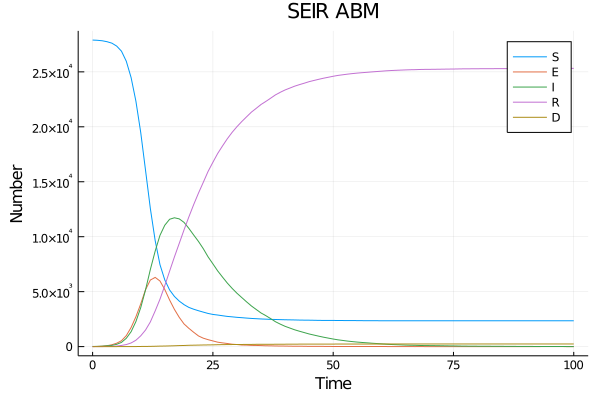

In [33]:
# Data Manipulation
data[!,:t] = t;
N_list = fill(N,nsteps+1)

# Select Theme
theme(:default)

# Plot
plot(t,data[:,2],label="S",
     xlab="Time",
     ylabel="Number",
     title="Agent-Based Metapopulation SEIRD", 
     legend=:right)
plot!(t,data[:,3],label="E")
plot!(t,data[:,4],label="I")
plot!(t,data[:,5],label="R")
plot!(t,data[:,6],label="D")
#plot!(t,N_list-data[:,2]-data[:,3]-data[:,4]-data[:,5], label="D")

In [14]:
#plotargs = (node_size = 0.2, method = :spring, linealpha = 0.4)
#plotabm(model; plotargs...)

In [34]:
delta_pop(x) = cgrad(:inferno)[count(a.pos == a.home for a in x) / length(x)]
infected_fraction(x) = cgrad(:inferno)[count(a.status == :I for a in x) / length(x)]

infected_fraction (generic function with 1 method)

In [41]:
model = initialize_model(provincial_pops, age_provincial_pops, contact_graph, mobility_graph,
                         α, β, γ, σ, h, I0)

g = model.space.graph
weight_matrix = LightGraphs.weights(g)
for i in 1:nv(g)
    weight_matrix[i,i] = 0
end

edgewidthsdict = Dict()
for node in 1:nv(g)
    nbs = neighbors(g,node)
    for nb in nbs
        edgewidthsdict[(node,nb)] = weight_matrix[node,nb] / sum([outneighbor for outneighbor in weight_matrix[node,:]])
    end
end

edgewidthsf(s,d,w) = edgewidthsdict[(s,d)]*3

plotargs = (node_size=0.15, method=:circular, linealpha=0.4, 
            aspect_ratio = 1, size = (800, 800), showaxis = false)

plotargs = merge(plotargs, (edgewidth = edgewidthsf,))

plotabm(model; ac=infected_fraction, plotargs...)

┌ Info: Saved animation to 
│   fn = /Users/Pit/GitHub/DigitalEpidemiologyProject/Notebooks/Modelling/Julia/anim.gif
└ @ Plots /Users/Pit/.julia/packages/Plots/6RLiv/src/animation.jl:104


Plots.AnimatedGif("/Users/Pit/GitHub/DigitalEpidemiologyProject/Notebooks/Modelling/Julia/anim.gif")
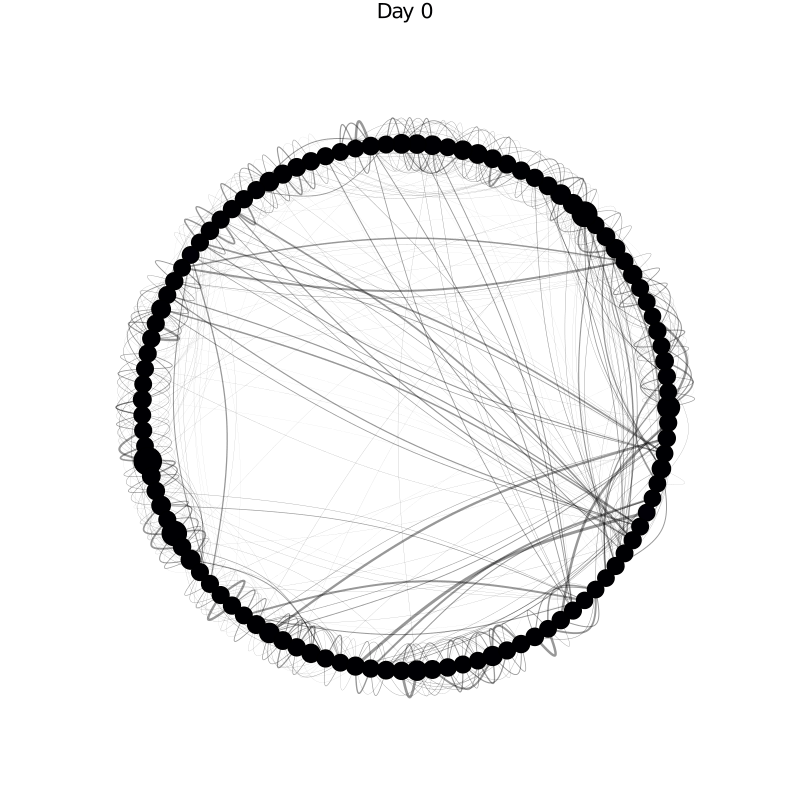

In [42]:
model = initialize_model(provincial_pops, age_provincial_pops, contact_graph, mobility_graph,
                         α, β, γ, σ, h, I0)

anim = @animate for i in 0:50
    i > 0 && step!(model, agent_step!, 1)
    p1 = plotabm(model; ac = infected_fraction, plotargs...)
    title!(p1, "Day $(i)")
end

gif(anim, "anim.gif", fps = 10)

![](anim.gif)